# Evaluation Example

This notebook reproduces the analysis at the start of Section 4.

### Setup
Follow the instructions `README.md` to download and setup the data files.

In [1]:
%matplotlib inline
import json
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10,10)

In [2]:
def load_result(file_path):
    with open(file_path) as f:
        return json.load(f)

In [3]:
get_qm = lambda r, qm='matthews_corr': r['al_history']['mvhistory'][qm]['values']

## Load files

Load summary result file.

In [4]:
data_path = '../data/output/evaluation_part2/results/'

In [5]:
id_a, id_b = 3188985034216692765, 14433445756144791964
df = pd.read_csv('../data/output/output.csv')
df = df.query('id in [@id_a, @id_b]').reset_index(drop=True)
df

,scenario,id,file_name,data_set,split_strategy,initial_pool_strategy,initial_pool_resample_version,initial_pool_num_labeled,model,init_strategy_C,...,pauc_average_gain,pauc_average_loss,pauc_learning_stability,pauc_ratio_of_outlier_queries,pauc_aulc,pauc_reyes_paulc,pauc_reyes_naulc,pauc_reyes_tpr,pauc_reyes_tnr,pauc_reyes_tp
0,evaluation_part2,3188985034216692765,Arrhythmia_withoutdupl_norm_05_v03_r01.csv,Arrhythmia,Sf,Pu,3,0,SVDDneg,TaxBound,...,0.040486,0.000000e+00,0.902184,0.09,70.535313,6.145749,64.389564,0.364372,0.000000e+00,2.239342
1,evaluation_part2,14433445756144791964,Arrhythmia_withoutdupl_norm_05_v03_r01.csv,Arrhythmia,Sf,Pu,3,0,SVDDneg,TaxBound,...,0.032051,-1.110223e-16,1.098901,0.07,71.474359,2.824786,68.649573,0.128205,-1.110223e-16,0.362152


In [6]:
def build_path(id):
    data = df.query('id == @id')[['file_name', 'qs', 'model']].values[0]
    s = '/'.join([data[0].split('_')[0], data[0].split('.')[0]])
    s += '_' + '_'.join(data[1:])
    s += f'_{id}.json'
    return s

Load raw result `.json` files for the selected experiments.

In [7]:
f1 = data_path + build_path(id_a)
f2 = data_path + build_path(id_b)

In [8]:
v1 = get_qm(load_result(f1))
v2 = get_qm(load_result(f2))

## Analysis

In [9]:
data = pd.DataFrame(np.c_[v1, v2], columns=['τ_HC', 'τ_NB'])

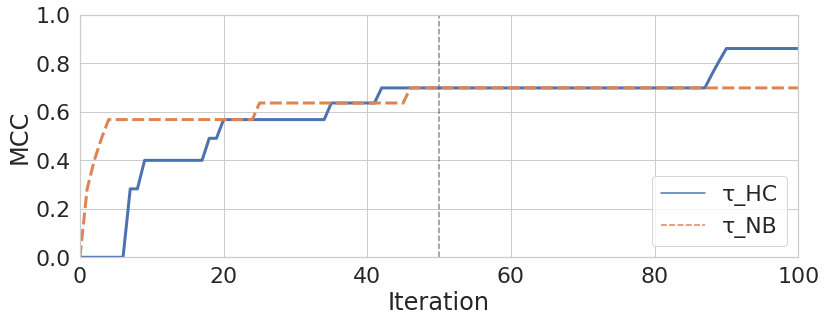

In [10]:
font_scale=2.0
sns.set_context("notebook", font_scale=font_scale)
fig, ax = plt.subplots()
_ = fig.set_size_inches((12, 5))
ax.axvline(x=50, color='k', linestyle='--', alpha=0.5)
sns.lineplot(data=data, linewidth=3, ax=ax)
ax.set_xlim(0, 100)
ax.set_ylim(0, 1)
ax.set_xlabel("Iteration")
ax.set_ylabel("MCC")
plt.legend(loc='lower right')
fig.tight_layout()
fig.savefig('../plots/eval_example_progress_curve.pdf')

Show the summary of the active-learning curves.

In [11]:
df[['qs', 'm_start_quality', 'm_end_quality', 'm_maximum', 'm_ramp_up', 'm_quality_range', 'm_total_quality_range',
       'm_average_end_quality', 'm_average_quality_change', 'm_average_gain',
       'm_average_loss', 'm_learning_stability', 'm_ratio_of_outlier_queries']].round(2)

,qs,m_start_quality,m_end_quality,m_maximum,m_ramp_up,m_quality_range,m_total_quality_range,m_average_end_quality,m_average_quality_change,m_average_gain,m_average_loss,m_learning_stability,m_ratio_of_outlier_queries
0,HighConfidencePQs,0.0,0.86,0.86,0.00,0.86,0.86,0.86,0.01,0.10,0.0,0.59,0.09
1,NeighborhoodBasedPQs,0.0,0.70,0.70,0.57,0.70,0.70,0.70,0.01,0.12,0.0,0.21,0.07


Inspect the step-wise learning stability.

In [12]:
k = 10
end = 100

In [13]:
v1 = np.array(v1)
v2 = np.array(v2)

In [14]:
diff1 = v1[k:end + 1] - v1[:end-k+1]
diff2 = v2[k:end + 1] - v2[:end-k+1]
qr_tot1 = v1[k:end + 1] - v1[0]
qr_tot2 = v2[k:end + 1] - v2[0]
ls1 = [diff1[i] / k / (qr_tot1[i] / (i + k)) if qr_tot1[i] != 0 else 0.0 for i in range(end - k + 1)]
ls2 = [diff2[i] / k / (qr_tot2[i] / (i + k)) if qr_tot2[i] != 0 else 0.0 for i in range(end - k + 1)]

In [15]:
data = pd.DataFrame(np.c_[ls1, ls2], columns=['τ_HC', 'τ_NB'])
data.index += k

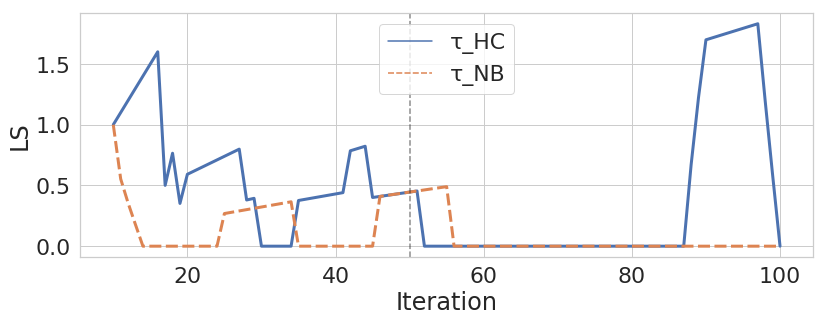

In [16]:
font_scale=2.0
sns.set_context("notebook", font_scale=font_scale)
fig, ax = plt.subplots()
_ = fig.set_size_inches((12, 5))
sns.lineplot(data=data, linewidth=3, ax=ax)
ax.axvline(x=50, color='k', linestyle='--', alpha=0.5)
ax.set_xlabel("Iteration")
ax.set_ylabel("LS")
fig.tight_layout()